We will calculate the NTK of a Bidirectional RNN in this notebook.

In [364]:
import numpy as np
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

In [365]:
from utils import clone_grads, paramdot, VErf3, VDerErf3

A bidirectional RNN with scalar output at every time step evolves like

$$
\begin{align*}

s^t_f(\xi_f) &= \phi(g^t_f(\xi_f) + u^t_f(\xi_f) + b) \\
g^t_f(\xi_f) &= Ws^{t-1}_f(\xi_f) \\
u^t_f(\xi_f) &= U\xi^t_f \\

s^t_b(\xi_b) &= \phi(g^t_b(\xi_b) + u^t_b(\xi_b) + b) \\
g^t_b(\xi_b) &= Ws^{t-1}_f(\xi_b) \\
u^t_b(\xi_b) &= U\xi^t_b \\

\end{align*}
$$

where

- $\xi^t_f \in \mathbb{R}^m$ is the input at time $t$ for forward inputs
- $\xi^t_b \in \mathbb{R}^m$ is the input at time $t$ for backward inputs
- $g^t_f \in \mathbb{R}^n$ is the previous state of the RNN weighted by W for forward inputs
- $g^t_b \in \mathbb{R}^n$ is the previous state of the RNN weighted by W for backward inputs
- $s^t_f(\xi) \in \mathbb{R}^n$ is the state of the RNN at time $t$ for forward inputs
- $s^t_b(\xi) \in \mathbb{R}^n$ is the state of the RNN at time $t$ for backward inputs
- $W \in \mathbb{R}^{n \times n}$ is the state-to-state weight matrix
- $U \in \mathbb{R}^{n \times m}$ is the input-to-state weight matrix
- $b \in \mathbb{R}^n$ is the bias
- $\phi$ is the nonlinearity

Simultaneously, two RNNs evolve with the same equations, but with the second using the input backwards. The two RNNs do not interact while calculating their output on each timestep independently.

We abbreviate $s^t = s^t(\xi)$ and $\bar s^t = s^t(\bar \xi)$, and likewise for other vectors $g^t, u^t$.

The final output can then be a variety of combinations of the two states of the RNNs. For this notebook, concatenation:

$$
\begin{align*}
        y^t &= \langle v, \frac{(s^t_f, s^t_b)}{\sqrt{2n}}\rangle
\end{align*}
$$


where 

- $v \in \mathbb{R}^{2n}$ is the readout weight
- $y^t \in \mathbb{R}$ is the output at time t

and the output is over $\sqrt{2n}$ because the output width has been doubled due to concatenation.
    
Typically, $\phi = \tanh$, but here, we will set $\phi = \mathrm{erf}$ because $\mathrm{erf}$ is very similar to $\tanh$ and it gives way to closed form expressions for the infinite-width limit.

For simplicity, suppose we sample

- $W_{\alpha \beta} \sim \mathcal{N}(0, \sigma^2_W / n)$
- $U_{\alpha \beta} \sim \mathcal{N}(0, \sigma^2_U / m)$
- $b_\alpha \sim \mathcal{N}(0, \sigma^2_b )$
- $v_\alpha \sim \mathcal{N}(0, \sigma^2_v )$

# Finite-Width Neural Network

In [366]:
import torch
import torch.nn as nn
class BidirectionalRNNClassifier(nn.Module):
    def __init__(self, indim, statedim, outdim=1, nonlin=torch.erf, varu=1, varw=1, varb=0, varv=1,
                avgpool=False, debug=False):
        super().__init__()
        self.varu = varu
        self.varw = varw
        self.varb = varb
        self.varv = varv
        self.nonlin = nonlin
        self.avgpool = avgpool
        self.debug = debug
        self.W = nn.Parameter(torch.randn(statedim, statedim))
        self.U = nn.Parameter(torch.randn(indim, statedim))
        self.b = nn.Parameter(torch.randn(statedim))
        self.v = nn.Parameter(torch.randn(statedim*2, outdim))
        self.randomize()
        
    def forward(self, inp, initstate=0):
        '''
        Input:
            inp: (batchsize, seqlen, indim)
        Output:
            out: (batchsize, outdim)
        '''
        indim = self.U.shape[0]
        statedim = self.U.shape[1]
        embed = torch.einsum(
            'ijk,kl->ijl', inp, self.U) / np.sqrt(indim) + self.b
        seqlen = inp.shape[1]
        statef = initstate
        stateb = initstate
        self._states = []
        self.hs = []
        for i in range(seqlen):
            hf = embed[:, i] + statef
            statef = self.nonlin(hf)
            hb = embed[:, seqlen-1-i] + stateb
            stateb = self.nonlin(hb)

            self._states.append(torch.cat((statef, stateb),1))
            if self.debug:
                state.retain_grad()
            # _states[i] = s^{i+1}
                self.hs.append(h)
            
            if i < seqlen - 1:
                statef = statef @ self.W / np.sqrt(statedim)
                stateb = stateb @ self.W / np.sqrt(statedim)
            else:
                if self.avgpool:
                    meanstate = sum(self._states) / len(self._states)
                    return meanstate @ self.v / np.sqrt(statedim)
                else:
                    return torch.cat((statef, stateb),1) @ self.v / np.sqrt(statedim)
        
    def randomize(self, varu=None, varw=None, varb=None, varv=None):
        varu = varu or self.varu
        varw = varw or self.varw
        varb = varb or self.varb
        varv = varv or self.varv
        with torch.no_grad():
            self.W.normal_(std=np.sqrt(varw))
            self.U.normal_(std=np.sqrt(varu))
            self.v.normal_(std=np.sqrt(varv))
            if varb > 0:
                self.b.normal_(std=np.sqrt(varb))
            else:
                self.b.zero_()

In [367]:
def simrnn_ntk(inputseqs, width, phi, varw=1, varu=1, varb=0, varv=1, seed=None, avgpool=False, debug=False):
    if seed is not None:
        torch.manual_seed(seed)
    indim = inputseqs[0].shape[1]
    rnn = BidirectionalRNNClassifier(indim, width, nonlin=phi,
                              varw=varw, varu=varu, varb=varb, varv=varv,
                              avgpool=avgpool, debug=debug)
    grads = []
    sgrads = []
    states = []
    hs = []
    for seq in inputseqs:
        out = rnn(seq.unsqueeze(0))
        out.backward()
        grads.append(clone_grads(rnn))
        if debug:
            # shape time x dim_s
            sgrads.append(clone_sgrads(rnn))
            states.append(clone_states(rnn))
            hs.append(clone_hs(rnn))
        rnn.zero_grad()
        
    batchsize = len(inputseqs)
    
    ntk = torch.zeros(batchsize, batchsize)
    for i in range(batchsize):
        for j in range(0, i+1):
            ntk[i, j] = ntk[j, i] = paramdot(grads[i], grads[j])
    
    if not debug:
        return dict(ntk=ntk)
    
    dscov = torch.zeros(batchsize, batchsize).tolist()
    scov = torch.zeros(batchsize, batchsize).tolist()
    hhcov = torch.zeros(batchsize, batchsize).tolist()
    for i in range(batchsize):
        for j in range(0, i+1):
            dscov[i][j] = (sgrads[i] @ sgrads[j].T).numpy()
            dscov[j][i] = dscov[i][j].T
            scov[i][j] = (states[i] @ states[j].T).numpy() / states[i].shape[-1]
            scov[j][i] = scov[i][j].T
            hhcov[i][j] = (hs[i] @ hs[j].T).numpy() / hs[i].shape[-1]
            hhcov[j][i] = hhcov[i][j].T
    return dict(ntk=ntk, dscov=np.block(dscov), scov=np.block(scov), hhcov=np.block(hhcov))

# Infinite-Width NTK

Consider two input sequences $\xi = \{\xi^1, \ldots, x^T \in \mathbb R^d\}$ and $\bar \xi = \{\bar \xi^1, \ldots, \bar \xi^{\bar T} \in \mathbb R^d \}$.

We calculate the NTK as is defined in the paper as 

$$
\begin{align*}
\Theta(\xi, \bar \xi) &= \langle \nabla_\theta f(\xi), \nabla_\theta f(\bar \xi) \rangle \\

\end{align*}
$$

And then simplify due to the concatenation of the output as

$$
\begin{align*}
&= \langle \nabla_\theta (f_f(\xi), f_b(\xi)), \nabla_\theta (f_f(\bar \xi),f_b(\bar \xi)) \rangle \\ 
&= \langle (\nabla_\theta f_f(\xi), \nabla_\theta f_b(\xi)), ( \nabla_\theta f_f(\bar \xi), \nabla_\theta f_b(\bar \xi)) \rangle \\

&= \langle \nabla_\theta f_f(\xi), \nabla_\theta f_f(\bar \xi) \rangle +  \langle \nabla_\theta f_b(\xi), \nabla_\theta f_b(\bar \xi) \rangle \\

&= \Theta_f(\xi, \bar \xi) + \Theta_b(\xi, \bar \xi) \\

\end{align*}
$$

In other words, we can calculate the NTK of the two forward RNNs and the two backward RNNs separately, and then sum them. If the output was added instead of concatenated (or some other way of combining the outputs), the formulation would be different.

## Forward

As with the simple RNN in the paper, we can think of each $g^t_f, u^t_f, s^t_f, g^t_b, u^t_b, s^t_b, b$ as having iid coordinates distributed resp. as some random variables $Z^{g^t_f}, Z^{u^t_f}, Z^{s^t_f}, Z^{g^t_b}, Z^{u^t_b}, Z^{s^t_b}, Z^{b}$. We can then write the following recursion

$$
\begin{align*}
2\mathbb{E}Z^{s^t}Z^{\bar s^r} &= \mathbb{E}(Z^{s^t_f},Z^{s^t_b})(Z^{\bar s^r_f},Z^{\bar s^r_b}) = \mathbb{E}Z^{s^t_f}Z^{\bar s^r_f} + Z^{s^t_b}Z^{\bar s^r_b}\\

&= \mathbb{E}\phi(Z^{g^t_f} + Z^{u^t_f} + Z^{b})\phi(Z^{\bar g^r_f} + Z^{\bar u^r_f} + Z^{b}) + \phi(Z^{g^t_b} + Z^{u^t_b} + Z^{b})\phi(Z^{\bar g^r_b} + Z^{\bar u^r_b} + Z^{b})\\
&= \mathbb{E}\phi(\zeta_1)\phi(\zeta_2) + \mathbb{E}\phi(\zeta_3)\phi(\zeta_4) 
\end{align*}
$$

where $(\zeta_1, \zeta_2) \sim \mathcal{N}\left(0, \mathbb{E}
\begin{pmatrix}
Z^{s^{t-1}_f}Z^{s^{t-1}_f} & Z^{s^{t-1}_f}Z^{s^{\bar r-1}_f}\\
Z^{s^{t-1}_f}Z^{s^{\bar r-1}_f} & Z^{s^{\bar r-1}_f}Z^{s^{\bar r-1}_f}
\end{pmatrix} + \frac{\xi^t_f\top\xi^r_f}{d}+\sigma^2_b
\right)$

and $(\zeta_3, \zeta_4) \sim \mathcal{N}\left(0, \mathbb{E}
\begin{pmatrix}
Z^{s^{t-1}_b}Z^{s^{t-1}_b} & Z^{s^{t-1}_b}Z^{s^{\bar r-1}_b}\\
Z^{s^{t-1}_b}Z^{s^{\bar r-1}_b} & Z^{s^{\bar r-1}_b}Z^{s^{\bar r-1}_b}
\end{pmatrix} + \frac{\xi^t_b\top\xi^r_b}{d}+\sigma^2_b
\right)$

This reflects the structure of GP kernel computation where, due to the concatenation, we can consider the forward RNN of the two inputs and the backward RNN of the two inputs as two separate RNNs.

The recursion then yields

$$C^{s^t, \bar s^r} = \lim_{n\to\infty}  \frac{s^{t\top} \bar s^r}{2n} = \mathbb{E}Z^{s^t}Z^{\bar s^r}/2$$

with the additional 2 due to the doubling of the output width.

However, this total $C$ is not actually used due to the formulation of the NTK. Instead, we only need $C^{s^t_o, \bar s^r_o}$ for a specific orientation


$$C^{s^t_o, \bar s^r_o} = \lim_{n\to\infty}  \frac{s^{t\top}_o \bar s^r_o}{n} = \mathbb{E}Z^{s^t_o}Z^{\bar s^r_o}$$

## Backward

The backward equation for either orientation $o$ is given by

$$
\begin{align*}
ds^{t-1}_o &= W^{\top}dg^t_o\\
dg^t_o &= du^t_o = \phi^\prime(g^t_o + u^t_o +b)\odot ds^t_o
\end{align*}
$$

We can then write another recursion like before,

$$
\begin{align*}
\mathbb{E}Z^{ds^t}Z^{d\bar s^r} &= \mathbb{E}(Z^{ds^t_f},Z^{ds^t_b})(Z^{d\bar s^r_f},Z^{d\bar s^r_b}) = \mathbb{E}Z^{ds^t_f}Z^{d\bar s^r_f} + \mathbb{E}Z^{ds^t_b}Z^{d\bar s^r_b}\\
\end{align*}
$$

For ease of notation and understanding, for either orientation $o$,

$$
\begin{align*}
\mathbb{E}Z^{ds^t_o}Z^{d\bar s^r_o} &= \mathbb{E}Z^{du^t_o}Z^{d\bar u^r_o} \\
&= \mathbb{E}\phi^\prime(Z^{g^{t+1}_o} + Z^{u^{t+1}_o} + Z^{b})Z^{ds^{t+1}_o}phi^\prime(Z^{\bar g^{r+1}_o} + Z^{\bar u^{r+1}_o} + Z^{b})Z^{d\bar s^{r+1}_o}\\
&= \mathbb{E}Z^{ds^{t+1}_o}Z^{d\bar s^{r+1}_o}\phi^\prime(Z^{g^{t+1}_o} + Z^{u^{t+1}_o} + Z^{b})\phi^\prime(Z^{\bar g^{r+1}_o} + Z^{\bar u^{r+1}_o} + Z^{b})\\


&= \mathbb{E}Z^{ds^{t+1}_o}Z^{d\bar s^{r+1}_o}\mathbb{E}\phi(\zeta_1)\phi(\zeta_2)
\end{align*}
$$

where $(\zeta_1, \zeta_2) \sim \mathcal{N}\left(0, \mathbb{E}
\begin{pmatrix}
Z^{s^{t}_o}Z^{s^{t}_o} & Z^{s^{t}_o}Z^{s^{\bar r}_o}\\
Z^{s^{t}_o}Z^{s^{\bar r}_o} & Z^{s^{\bar r}_o}Z^{s^{\bar r}_o}
\end{pmatrix} + \sigma^2_U\frac{\xi^t_o\top\xi^r_o}{d}+\sigma^2_b
\right)$


This yields

$$
\begin{align*}
D^{s^t_o, \bar s^r_o} &= \lim_{n\to\infty} \frac{ds^{t\top}_o d\bar s^r_o}{n} = \mathbb{E}Z^{ds^t_o}Z^{d\bar s^r_o}\\
&= D^{s^{t+1}_o, \bar s^{r+1}_o}\mathbb{E}\phi^\prime(\zeta_1)\phi^\prime(\zeta_2)
\end{align*}
$$

where $(\zeta_1, \zeta_2) \sim \mathcal{N}\left(0, 
\begin{pmatrix}
C^{s^t_o, s^t_o} & C^{s^t_o, \bar s^r_o}\\
C^{s^t_o, \bar s^r_o} & C^{\bar s^r_o, \bar s^r_o}
\end{pmatrix} + \sigma^2_U\frac{\xi^t_o\top\xi^r_o}{d}+\sigma^2_b
\right)$

which we can use to find 

$$
D^{g^t_o, \bar g^r_o} = D^{u^t_o, \bar u^r_o} = \sigma^{-2}_W D^{s^{t-1}_o, \bar s^{r-1}_o}
$$

Using LastState, the initial conditions are:

$$
\begin{align*}
C^{s^0_o, \bar s^r_o}C^{s^r_o, \bar s^0_o} &= 0\\
D^{s^T_o, \bar s^{\bar T}_o} &= \sigma^2_v\\
D^{s^T_o, \bar s^{r}_o} &= D^{s^r_o, \bar s^{\bar T}_o} = 0, \quad otherwise
\end{align*}
$$


## Infinite-Width NTK

The final NTK can then be calculated as

$$
\begin{align*}
\mathring{\Theta}(\xi, \bar \xi) &= \mathring{\Theta}_f(\xi, \bar \xi) + \mathring{\Theta}_b(\xi, \bar \xi) \\

\mathring{\Theta}_o(\xi, \bar \xi) &= \sum^T_{i=1}D^{g^{i+1}_o, \bar g^{i+1}_o} C^{s^{i}_o, \bar s^{i}_o} + \sum^T_{i=1}D^{g^{i}_o, \bar g^{i}_o} \frac{\xi^i \bar \xi^i}{d} + \sum^T_{i=1}D^{g^{i}_o, \bar g^{i}_o} + C^{s^{T}_o, \bar s^T_o}

\end{align*}
$$

Operating along the diagonal of $D^{s^{i}, \bar s^{i}}$ as we are using only LastState and not AvgPool.


In [368]:
def rnnntk_batch(ingram, Vphi3, Vderphi3,
    varw=1, varu=1, varb=0, varv=1, avgpool=False):
    ''' Compute the RNN-NTK over a batch of sequences of the same length
    Inputs:
        `ingram`: dimension-normalized Gram matrix between all tokens across all input sequences
            of shape [batchsize, batchsize, seqlen, seqlen]
        `Vphi3`: V-transform of nonlin that takes in 3 input arrays (cov, var1, var2)
        `Vderphi3`: V-transform of nonlin derivative that takes in 3 input arrays (cov, var1, var2)
        `varw`: variance of state-to-state weights
        `varu`: variance of input-to-state weights
        `varb`: variance of biases
        `varv`: variance of output weights
        `avgpool`: if True, output is the average of all states multiplied by output weights.
            Otherwise, output is just the last state multiplied by output weigths.
    Outputs:
        a dictionary of kernels
        output['ntk'] gives the NTK
        '''

    ingram_b = np.zeros(ingram.shape)
    ingram_b[0,0,...]= ingram[0,0,...][::-1, ::-1]
    ingram_b[0,1,...]= ingram[0,1,...][::-1, ::-1]
    ingram_b[1,0,...]= ingram[1,0,...][::-1, ::-1]
    ingram_b[1,1,...]= ingram[1,1,...][::-1, ::-1]

    seqlen = ingram.shape[-1]
    batchsize = ingram.shape[0]
    # hcov[ia, jb] = < h^(i+2,a), h^(j+2,b) >
    hcov_f = np.zeros(ingram.shape)
    hcov_b = np.zeros(ingram.shape)
    # hhcov[ia, jb] = < \tilde h^(i+1,a), \tilde h^(j+1,b) >
    hhcov_f = np.zeros(ingram.shape)
    hhcov_f[..., 0, :] = varu * ingram[..., 0, :] + varb
    hhcov_f[..., :, 0] = varu * ingram[..., :, 0] + varb

    hhcov_b = np.zeros(ingram.shape)
    hhcov_b[..., 0, :] = varu * ingram_b[..., 0, :] + varb
    hhcov_b[..., :, 0] = varu * ingram_b[..., :, 0] + varb
    
    # fill in zeroed entries
    def reflect(t):
        return np.where(t==0, np.moveaxis(t, [0, 2], [1, 3]), t)
    def hhcov_o_prep(hhcov_o, i=None, b=0):
        if i is None:
            d = np.einsum('aaii->ai', hhcov_o)
            return np.broadcast_arrays(
                hhcov_o,
                d.reshape(batchsize, 1, seqlen, 1),
                d.reshape(1, batchsize, 1, seqlen)
            )
        return np.broadcast_arrays(
            hhcov_o[..., i, b:i+1],
            np.diag(hhcov_o[..., i, i]).reshape(batchsize, 1, 1),
            np.einsum('aaii->ai', hhcov_o[..., b:i+1, b:i+1]).reshape(1, batchsize, i+1-b)
        )
    def Vderphi(mat):
        d = np.diag(mat)
        return Vderphi3(mat, d.reshape(-1, 1), d.reshape(1, -1))
    
    for i in range(0, seqlen):
        hcov_f[..., i, :i+1] = varw * Vphi3(*hhcov_o_prep(hhcov_f, i))
        hcov_b[..., i, :i+1] = varw * Vphi3(*hhcov_o_prep(hhcov_b, i))

        if i < seqlen - 1:
            hhcov_f[..., i+1, 1:i+2] = hcov_f[..., i, :i+1] + varu * ingram[..., i+1, 1:i+2] + varb
            hhcov_b[..., i+1, 1:i+2] = hcov_b[..., i, :i+1] + varu * ingram_b[..., i+1, 1:i+2] + varb

    hhcov_f = reflect(hhcov_f)
    hcov_f = reflect(hcov_f)
    scov_f = varw**-1 * hcov_f

    hhcov_b = reflect(hhcov_b)
    hcov_b = reflect(hcov_b)
    scov_b = varw**-1 * hcov_b
    
    if not avgpool:
        dhcov_f = np.zeros([batchsize, batchsize, seqlen+1])
        dhcov_f[..., -1] = varv

        dhcov_b = np.zeros([batchsize, batchsize, seqlen+1])
        dhcov_b[..., -1] = varv

        for i in range(seqlen-1, -1, -1):
            dhcov_f[..., i] = varw * Vderphi(hhcov_f[..., i, i]) * dhcov_f[..., i+1]
            dhcov_b[..., i] = varw * Vderphi(hhcov_b[..., i, i]) * dhcov_b[..., i+1]

        dhcov_f /= varw
        dhcov_f = dhcov_f[..., :-1]

        dhcov_b /= varw
        dhcov_b = dhcov_b[..., :-1]

        buf_f = np.einsum('abii->abi', ingram) + 1
        buf_f[..., 1:] += np.einsum('abii->abi', scov_f[..., :-1, :-1])
        ntk_f = np.einsum('abi,abi->ab', dhcov_f, buf_f)
        ntk_f += scov_f[..., -1, -1]

        buf_b = np.einsum('abii->abi', ingram_b) + 1
        buf_b[..., 1:] += np.einsum('abii->abi', scov_b[..., :-1, :-1])
        ntk_b = np.einsum('abi,abi->ab', dhcov_b, buf_b)
        ntk_b += scov_b[..., -1, -1]
        return ntk_f + ntk_b

    raise "not implemented"

# Theory vs Simulation

We verify that as width increases, the empirical finite-width NTK converges to the theoretical infinite-width NTK.

## Data

In [369]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


We treat the first 5 pixels (3 channels each) as the "tokens" in a sequence of 5. We use the first 2 images from CIFAR10 for our 2 sequences.

In [370]:
M = 2
T = 5

inps = torch.stack([v[0].reshape(3, -1)[:, :T].T for i, v in enumerate(trainset)
                 if i < M]).numpy()
inpcov = np.einsum('ais,bjs->aibj', inps, inps) / inps.shape[-1]
inpcov = np.moveaxis(inpcov, 1, 2)

## Verify

In [371]:
varw = 1
varu = 2
varb = 0.2
varv = 1
avgpool = False

In [372]:

def VErf(cov):
    '''
    Computes E[erf(z) erf(z)^T | z ~ N(0, `cov`)]
    where z is a multivariate Gaussian with mean 0 and covariance `cov`

    Inputs:
        `cov`: An array where the last 2 dimensions contain covariance matrix of z (and the first dimensions are "batch" dimensions)
    Output:
        a numpy array of the same shape as `cov` that equals the
        expectation above in the last 2 dimensions.
    '''
    ll = list(range(cov.shape[-1]))
    d = np.sqrt(cov[..., ll, ll] + 0.5)

    c = d[..., None]**(-1) * cov * d[..., None, :]**(-1)
    return 2./np.pi * np.arcsin(np.clip(c, -1, 1))


def VDerErf(cov):
    '''
    Computes E[erf'(z) erf'(z)^T | z ~ N(0, `cov`)]
    where erf' is the derivative of erf and
    z is a multivariate Gaussian with mean 0 and covariance `cov`

    Inputs:
        `cov`: An array where the last 2 dimensions contain covariance matrix of z (and the first dimensions are "batch" dimensions)
    Output:
        a numpy array of the same shape as `cov` that equals the
        expectation above in the last 2 dimensions.
    '''
    ll = list(range(cov.shape[-1]))
    d = np.sqrt(cov[..., ll, ll])
    dd = 1 + 2 * d
    return 4/np.pi * (dd[..., None] * dd[..., None, :] - 4 * cov**2)**(-1./2)

thcov = rnnntk_batch(inpcov, VErf3, VDerErf3, varw, varu, varb, varv, avgpool=avgpool)

In [373]:
def NTK_theory_vs_sim(inpseqs, infntk, varw, varu, varb, avgpool,
                      nonlin=torch.erf,
                      log2widthmin=6, log2widthmax=15, nseeds=10):
    if isinstance(inpseqs, np.ndarray):
        inpseqs = torch.from_numpy(inpseqs).float()
    widths = 2**np.arange(log2widthmin, log2widthmax)
    mysimcovs = {}
    for width in tqdm(widths):
        mysimcovs[width] = np.stack([
            simrnn_ntk(inpseqs, width,
                       nonlin, varw, varu, varb,
                       seed=seed, avgpool=avgpool, debug=False)['ntk']
            for seed in range(nseeds)])
    frobs = []
    infntknorm = np.linalg.norm(infntk)
    for width in widths:
        _frobs = np.sum((mysimcovs[width] - infntk)**2,
                        axis=(1, 2)) / infntknorm**2
        for f in _frobs:
            frobs.append(dict(
                relfrob=np.sqrt(f),
                width=width
            ))
    return pd.DataFrame(frobs)

We measured the relative Frobenius norm of the finite-width deviation = $\|\Theta - \mathring \Theta\|_F / \|\mathring \Theta\|_F$, where $\Theta$ and $\mathring \Theta$ are resp. the finite (empirical) and infinite-width (theoretical) NTKs.

In [374]:
frob_df = NTK_theory_vs_sim(inps, thcov, varw, varu, varb,
                           avgpool=avgpool, log2widthmax=14, nseeds=100)

100%|██████████| 8/8 [11:38<00:00, 87.25s/it]


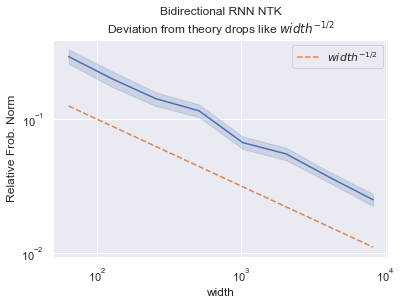

In [375]:
sns.lineplot(data=frob_df, x='width', y='relfrob')
widths = frob_df.width.unique()
plt.plot(widths, np.array(widths, dtype='float')**-0.5, '--', label=u'${width}^{-1/2}$')
plt.ylabel(u'Relative Frob. Norm')
plt.loglog()
plt.legend()
_ = plt.title(u'Bidirectional RNN NTK\nDeviation from theory drops like $width^{-1/2}$')

In [376]:
frob_df.to_pickle('birnn_ap_ntk.frob')